In [25]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.utils.rnn import pad_sequence
from einops import rearrange
import matplotlib.pyplot as plt
from biovlp.datasets.mimic_cxr_dataset import MIMICCXRDataset
from biovlp.datasets.temporal_mimic_cxr_dataset import TemporalMIMICCXRDataset, temporal_collate_fn
from biovlp.datasets.datamodule import DataModule
from transformers import GPT2TokenizerFast
from biovlp.models.temporal_model import TemporalReportGenerationModule

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
model = TemporalReportGenerationModule.load_from_checkpoint(
    # "/home/r15user2/Documents/Multi-seq-mae/data/report_generation/temporal_decoder_2023_10_10_23_05_10/ckpts/epoch=25-step=84760.ckpt"
    "/home/r15user2/Documents/Multi-seq-mae/data/report_generation/temporal_decoder_2023_10_20_11_53_00/ckpts/last.ckpt"
)

# language_model = "distilgpt2"
# tokenizer = GPT2TokenizerFast.from_pretrained(language_model)
# tokenizer.add_special_tokens(
#     {"bos_token": "[BOS]", 'pad_token': '[PAD]'})
# annotation_file = "/home/r15user2/Documents/CXR_dataset/temporal_CXR/mimic_annotation.json"
# dataset_dir = "/home/r15user2/Documents/CXR_dataset/mimic_data/2.0.0/files"
# dm = DataModule(TemporalMIMICCXRDataset, tokenizer, annotation_file, dataset_dir,
#                 batch_size=4, collate_fn=temporal_collate_fn)
# for batch in dm.test_dataloader():
#     break

Description, Special token, Index
bos_token, [BOS], 50257
eos_token, <|endoftext|>, 50256
unk_token, <|endoftext|>, 50256
pad_token, [PAD], 50258
=> merge config from /home/r15user2/Documents/Multi-seq-mae/biovlp/backbones/../../biovlp/ext/cvt/experiments/imagenet/cvt/cvt-21-384x384.yaml


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.2.crossattention.c_attn.weight', 'transformer.h.3.crossattention.q_attn.weight', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.4.crossattention.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.4.ln_cross_attn.weight', 'transformer.h.5.ln_cross_attn.weight', 'transformer.h.3.crossattention.c_attn.weight', 'transformer.h.3.ln_cross_attn.weight', 'transformer.h.2.crossattention.masked_bias', 'transformer.h.2.crossattention.bias', 'transformer.h.5.crossattention.c_attn.weight', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_proj.weight', 'transformer.h.5.crossattention.q_attn.weight', 'transformer.h.4.crossattention.c_proj.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.3.crossattention.masked_bias', 'transformer.h.5.crossattention.masked_bias', 'transformer.h.4.crossattention.c

Load pretrained distillgpt2
number of parameters: 14.18M


In [42]:
for idx, batch in enumerate(model.datamodule.test_dataloader()):
    if idx == 1:
        break

Map:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [43]:
with torch.no_grad():
    images = batch["images"]
    batch_mask = batch["batch_mask"]
    study_date = batch["study_date"]
    batch_len = batch_mask.sum(dim=1)

    B, T, C, H, W = images.shape
    nonull_images = images[batch_mask]
    if "cvt" in model.visual_model:
        image_features = model.encoder(nonull_images)['last_hidden_state']
        image_features = image_features.permute(0, 2, 1)
        image_features = model.encoder_compact(image_features)
    elif model.visual_model == "vit_base_patch16_384":
        image_features = model.encoder(nonull_images, return_features=True)
        image_features = image_features[:, 1:]
    elif model.visual_model == "resnet_50":
        # setup forward for biovil-T
        _, image_features = model.encoder(nonull_images)
    else:
        raise NotImplementedError
    del images
    image_embs = model.encoder_projection(image_features)

    nonull_image_embs_list = torch.split(
        image_embs, batch_len.tolist(), dim=0)
    pad_image_embs = pad_sequence(
        nonull_image_embs_list, batch_first=True)
    pad_img_len = model.max_seq_len - pad_image_embs.shape[1]
    B, _, N, D = pad_image_embs.shape
    zero_image_embs = torch.zeros(
        B, pad_img_len, N, D).type_as(image_embs)
    image_embs = torch.cat(
        [pad_image_embs, zero_image_embs], dim=1)

    temporal_image_embs, atten_weights = model.visual_temporal_aggregator(
        image_embs, study_date, return_atten=True)
    temporal_image_embs = rearrange(
        temporal_image_embs, "b (t n) d -> (b t) n d", b=B, t=T)
    temporal_img_embs = temporal_image_embs[batch_mask.reshape(
        -1)]

In [44]:
atten_weights.shape

torch.Size([4, 250, 250])

<Axes: >

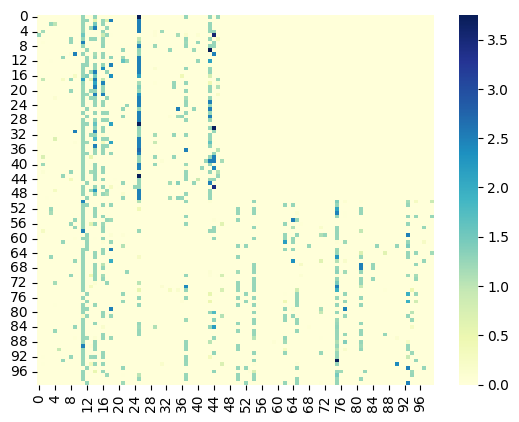

In [52]:
import seaborn as sns
import torch.nn.functional as F

# weight = attention_weights[0]
# weight = F.softmax(atten_weights[0], dim=-1)
sns.heatmap(atten_weights.cpu().numpy()[0][:100, :100] * 10, cmap="YlGnBu")

In [46]:
atten_weights[0].shape

torch.Size([250, 250])

In [50]:
atten_weights[0][:100, :100].topk(5, dim=-1)[0]

tensor([[0.3750, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.2500, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.1489, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.2500, 0.1250, 0.1250, 0.1250],
        [0.2496, 0.1262, 0.1253, 0.1250, 0.1250],
        [0.3559, 0.1544, 0.1250, 0.1250, 0.1154],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.2499, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.1279, 0.1250, 0.1250, 0.1250],
        [0.3745, 0.1286, 0.1250, 0.1250, 0.1249],
        [0.2500, 0.2491, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.1294, 0.1251, 0.1250, 0.1250],
        [0.2500, 0.2151, 0.1599, 0.1250, 0.1250],
        [0.2500, 0.2476, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.2377, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.2500, 0.1250, 0.1250, 0.1250],
        [0.2348, 0.2082, 0.1488, 0.1406, 0.1250],
        [0.2500, 0.2166, 0.1250, 0.1225, 0.0978],
        [0.2465, 0.2067, 0.1250, 0.1250, 0.1250],
        [0.2500, 0.1420, 0.1250, 0.1250, 0.1250],


In [51]:
atten_weights[0][:100, :100].topk(5, dim=-1)[1]

tensor([[25, 11, 14, 43, 37],
        [25, 18, 11, 16, 12],
        [25, 14, 43, 11,  3],
        [14, 25, 11, 43, 17],
        [25, 44, 16, 43, 11],
        [44, 11, 17,  0, 35],
        [14, 11,  8, 43, 37],
        [11, 40, 16, 25, 44],
        [25, 16, 11, 43, 44],
        [43, 25, 12, 33, 21],
        [44,  9, 11, 16, 25],
        [25, 18, 14, 16, 12],
        [25, 43, 21, 40, 12],
        [25, 18, 14, 16, 11],
        [25, 16, 37, 11, 43],
        [25, 14, 43, 11, 17],
        [18, 25, 14, 12, 11],
        [14, 11,  8, 45,  1],
        [16, 14, 11, 34, 37],
        [14, 25, 11, 43, 34],
        [16,  8, 11, 14, 43],
        [14, 16, 25, 11, 12],
        [25, 14, 11, 43, 17],
        [43, 25, 14, 11, 37],
        [25, 11, 43, 37, 14],
        [43, 35, 25, 21, 12],
        [25, 43, 11, 14, 37],
        [43, 25, 36, 12, 21],
        [25, 11, 14, 43, 37],
        [25, 18, 14, 12, 11],
        [44, 14, 11, 25, 43],
        [ 9, 14, 44, 25, 11],
        [11, 43, 14, 34, 25],
        [2

frontal and lateral views of the chest . the lungs are clear of consolidation or effusion . right pleural based thickening at the base laterally is again seen . there is no evidence of pulmonary vascular congestion . cardiomediastinal silhouette is stable in . no acute osseous abnormality detected .
the cardiomediastinal and hilar contours are stable . the aorta is again noted to be tortuous . the patient is status post cabg with median sternotomy wires in place . the second most superior median sternotomy wires again noted to be fractured . there is no pleural effusion or pneumothorax . the lungs are well-expanded with stable scarring at the right costophrenic angle . there is no new focal consolidation concerning for pneumonia . there is no overt pulmonary edema . the upper abdomen is unremarkable aside from surgical clips .


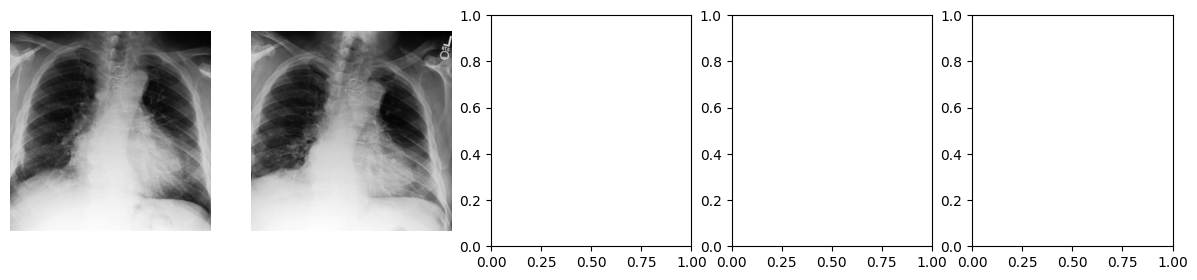

In [49]:
mean = torch.tensor([[0.485, 0.456, 0.406]])
mean = torch.repeat_interleave(mean, 5, dim=0)
mean = mean.unsqueeze(-1).unsqueeze(-1)
std = torch.tensor([[0.229, 0.224, 0.225]])
std = torch.repeat_interleave(std, 5, dim=0)
std = std.unsqueeze(-1).unsqueeze(-1)

idx = 0
viz_images = batch["images"][idx] * std + mean
viz_images = viz_images.permute(0, 2, 3, 1)
report = batch["report"][idx]
mask = batch["batch_mask"][idx]

fig, axes = plt.subplots(1, 5)
fig.set_figheight(3)
fig.set_figwidth(15)
for i in range(len(viz_images)):
    if mask[i]:
        axes[i].imshow(viz_images[i])
        axes[i].set_axis_off()
        print(report[i])